Reference: https://keras.io/examples/generative/ddim/

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import layers
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras.optimizers import Adam
from keras.losses import mean_absolute_error

In [2]:
# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

optimizer = Adam(0.0002, 0.5)

In [3]:
batch_size = 8
image_size = 256
channels = 1

def preprocessing_function(image):
    image = image.astype(float) / 255
    return image

idg = ImageDataGenerator(preprocessing_function = preprocessing_function)
heightmap_iterator = idg.flow_from_directory('data/split_heightmaps', 
                                             target_size = (image_size, image_size), 
                                             batch_size = batch_size,
                                             color_mode = 'grayscale',
                                             classes = [''])

Found 37692 images belonging to 1 classes.


In [4]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

In [5]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

In [6]:
def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply

In [7]:
def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [8]:
def create_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, channels))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(channels, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")

In [9]:
network = create_network(image_size, widths, block_depth)
network.compile(optimizer = optimizer, loss = mean_absolute_error)

In [10]:
def diffusion_schedule(diffusion_times):
    # diffusion times -> angles
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    # angles -> signal and noise rates
    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)
    # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

    return noise_rates, signal_rates

In [11]:
def denoise(noisy_images, noise_rates, signal_rates, model):
    pred_noises = model.predict([noisy_images, noise_rates**2])
    pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
    
    return pred_noises, pred_images

In [12]:
def train(directory_iterator, model, epochs):
    steps_per_epoch = directory_iterator.__len__()
    
    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            images = np.asarray(directory_iterator.next()[0])
            noises = tf.random.normal(shape=(batch_size, image_size, image_size, channels))

            diffusion_times = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0)
            noise_rates, signal_rates = diffusion_schedule(diffusion_times)

            noisy_images = signal_rates * images + noise_rates * noises
            pred_noises, pred_images = denoise(noisy_images, noise_rates, signal_rates, model)
            model.train_on_batch([noisy_images, noise_rates**2], pred_noises)
    
    return model

In [ ]:
network = train(heightmap_iterator, network, 1)

In [14]:
def reverse_diffusion(model, num_images, diffusion_steps):
    initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, channels))
    step_size = 1.0 / diffusion_steps
    
    next_noisy_images = initial_noise
    for step in range(diffusion_steps):
        noisy_images = next_noisy_images
        
        diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
        noise_rates, signal_rates = diffusion_schedule(diffusion_times)
        
        #pred_noises = model.predict([noisy_images, noise_rates**2])
        pred_noises = model([noisy_images, noise_rates**2], training = True)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = diffusion_schedule(next_diffusion_times)
        next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
        
    return pred_images

In [17]:
generated_images = reverse_diffusion(network, num_images = 10, diffusion_steps = 20)

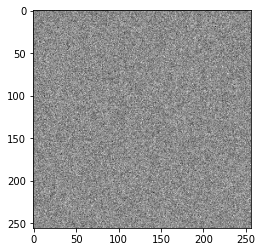

In [18]:
plt.imshow(generated_images[0], cmap='gray')

In [ ]:
#############################################################

In [ ]:
def reverse_diffusion(self, initial_noise, diffusion_steps):
    # reverse diffusion = sampling
    num_images = initial_noise.shape[0]
    step_size = 1.0 / diffusion_steps

    # important line:
    # at the first sampling step, the "noisy image" is pure noise
    # but its signal rate is assumed to be nonzero (min_signal_rate)
    next_noisy_images = initial_noise
    for step in range(diffusion_steps):
        noisy_images = next_noisy_images

        # separate the current noisy image to its components
        diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )
        # network used in eval mode

        # remix the predicted components using the next signal and noise rates
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = self.diffusion_schedule(
            next_diffusion_times
        )
        next_noisy_images = (
            next_signal_rates * pred_images + next_noise_rates * pred_noises
        )
        # this new noisy image will be used in the next step

    return pred_images

In [11]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)